In [1]:
from codecarbon import EmissionsTracker
from codecarbon import track_emissions
# Load the ROUGE metric
import evaluate
from evaluate import load

import pandas as pd

/Users/lala/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!ollama list

NAME             ID              SIZE      MODIFIED   
llama3:8b        365c0bd3c000    4.7 GB    2 days ago    
llama3:latest    365c0bd3c000    4.7 GB    2 days ago    


In [3]:
# read files(src)
# 1 筆一行，||||| 分 document
'''f = open("./Data/train.src.txt","r")
train_data = f.readlines()
f.close()'''

f = open("./Data/test.src.txt","r")
test_data = f.readlines()
f.close()

'''f = open("./Data/val.src.txt","r")
val_data = f.readlines()
f.close()'''

print(f"test: {len(test_data)}")#(f"train: {len(train_data)}\ntest: {len(test_data)}\nval: {len(val_data)}")

test: 5622


In [4]:
f = open("./Data/test.txt","r")
test_result = f.readlines()
f.close()

print(test_result[0])
print(len(test_result))

– It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.

5622


In [5]:
import requests

def chat_with_ollama(document, model="llama3:8b"):
    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
    data = {
        "model": model,
        "messages":[{"role": "system", "content": "Summarize the text into a short. Output only the summary itself."},""],
        # "prompt": "Summarize the following text into a short. Output only the summary itself.\n\n"+prompt,
        "stream": False  # 設為 True 可以接收串流回傳
    }

    summary = ""
    for content in document.split("|||||"):
        data["messages"][1] = {"role": "user", "content": content}
        response = requests.post(url, headers=headers, json=data)
        result = response.json()
        summary += result['message']['content'] + "\n"
        
    data["messages"][0] = {"role": "system", "content": "Cobine the summaries and provide a comprehensive summary. Output only the summary itself."}
    response = requests.post(url, headers=headers, json=data)
    result = response.json()
    return result['message']['content']

#print(test_data[0])
print(chat_with_ollama(test_data[0]))

Voters in 11 states will pick their governors tonight, with Republicans expected to increase their numbers by at least one and potentially hold more than two-thirds of the nation's top state offices. Eight gubernatorial seats currently held by Democrats are up for grabs, while three are held by Republicans. Polls suggest that only three contests are competitive: Montana, New Hampshire, and Washington. Republicans are likely to win governorships in North Carolina, Utah, North Dakota, and Indiana, while Democrats may hold onto their seats in West Virginia, Missouri, Vermont, and Delaware.


In [6]:
candidates = []
data_num = 10

@track_emissions()
def summarize():
    for document in test_data[:data_num]:
        candidates.append(chat_with_ollama(document))
        
summarize()

[codecarbon WARNING @ 18:06:25] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 18:06:25] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 18:06:25] [setup] RAM Tracking...
[codecarbon INFO @ 18:06:25] [setup] CPU Tracking...


[codecarbon WARNING @ 18:06:25] We saw that you have a Apple M2 Max but we don't know it. Please contact us.
[codecarbon WARNING @ 18:06:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 18:06:25] CPU Model on constant consumption mode: Apple M2 Max
[codecarbon WARNING @ 18:06:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:06:25] [setup] GPU Tracking...
[codecarbon INFO @ 18:06:25] No GPU found.
[codecarbon INFO @ 18:06:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 18:06:25] >>> Tracker's metadata:
[codecarbon INFO @ 18:06:25]   Platform system: macOS-15.2-arm64-arm-64bit
[codecarbon INFO @ 18:06:25]   Python versi

In [7]:
references = [i.strip("– ") for i in test_result[:data_num]]
print(references[0])

It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.



In [8]:
# rouge
rouge = evaluate.load('rouge')
results_R = rouge.compute(predictions=candidates, references=references) #結果平均

print("ROUGE:")
print(f"rouge1: {results_R['rouge1']}\nrouge2: {results_R['rouge2']}\nrougeL: {results_R['rougeL']}\nrougeLsum: {results_R["rougeLsum"]}")

ROUGE:
rouge1: 0.3378744615661706
rouge2: 0.10599573592633435
rougeL: 0.18710118589737207
rougeLsum: 0.189987337238802


In [9]:
# bleu
# 不需要 brevity_prnalty，可能要考慮手動算 bleu(無BP)
bleu = evaluate.load('bleu')
results_B = bleu.compute(predictions=candidates, references=references)
print("BLEU:")
print(f"bleu: {results_B['bleu']}\nprecisions: {results_B['precisions']}\nbrevity_penalty: {results_B['brevity_penalty']}\nlength_ratio: {results_B["length_ratio"]}\ntranslation_length: {results_B["translation_length"]}\nreference_length: {results_B["reference_length"]}")

BLEU:
bleu: 0.037314317830048384
precisions: [0.5402930402930403, 0.16358595194085027, 0.0708955223880597, 0.03672316384180791]
brevity_penalty: 0.3029646357019853
length_ratio: 0.4557595993322204
translation_length: 1092
reference_length: 2396


In [10]:
'''results_R = {}
results_R['rouge1'] = 0.3042215287471872
results_R['rouge2'] = 0.08818775179799443
results_R['rougeL'] =  0.1639229255348068
results_R['rougeLsum'] = 0.16663142006267556

results_B = {}
results_B['bleu'] = 0.02515597115661552

print(results_R)'''

"results_R = {}\nresults_R['rouge1'] = 0.3042215287471872\nresults_R['rouge2'] = 0.08818775179799443\nresults_R['rougeL'] =  0.1639229255348068\nresults_R['rougeLsum'] = 0.16663142006267556\n\nresults_B = {}\nresults_B['bleu'] = 0.02515597115661552\n\nprint(results_R)"

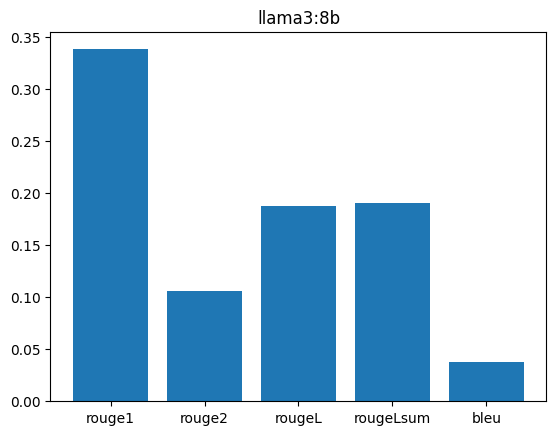

In [11]:
import matplotlib.pyplot as plt

x = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleu']
y = [results_R[r] for r in x[:4]] + [results_B['bleu']]
plt.bar(x,y)
plt.title("llama3:8b")
plt.show()

# codecarbon show
carbonboard --filepath="emissions.csv"
http://127.0.0.1:8050/